# Boston Fire Incident Reports — EDA & Bias Analysis

**Dataset:** [Fire Incident Reports](https://data.boston.gov/dataset/fire-incident-reports)  
**Source:** City of Boston — CKAN DataStore API  
**Notebook purpose:** Perform exploratory data analysis on fire incident records, identify potential biases in the data, and apply basic mitigation strategies.

---
## 0 · Imports & Configuration

In [1]:
import warnings
warnings.filterwarnings("ignore")

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

try:
    from fairlearn.metrics import MetricFrame, count
    HAS_FAIRLEARN = True
except ImportError:
    HAS_FAIRLEARN = False
    print("Fairlearn not installed – run: pip install fairlearn")

sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams["figure.dpi"] = 120

RESOURCE_ID = "91a38b1f-8439-46df-ba47-a30c48845e06"
BASE_URL    = "https://data.boston.gov/api/3/action/datastore_search"
BATCH_SIZE  = 10_000

print("Ready.")

Ready.


---
## 1 · Data Ingestion

In [2]:
def fetch_all_records(resource_id: str, batch_size: int = 10_000) -> pd.DataFrame:
    """Paginate through CKAN DataStore and return all records as a DataFrame."""
    all_records, offset = [], 0
    params = {"resource_id": resource_id, "limit": batch_size, "offset": 0}

    resp = requests.get(BASE_URL, params=params, timeout=60)
    resp.raise_for_status()
    data = resp.json()
    if not data.get("success"):
        raise RuntimeError(f"API error: {data.get('error')}")

    result = data["result"]
    total  = result["total"]
    print(f"Total records: {total:,}")
    all_records.extend(result["records"])
    offset += batch_size

    while offset < total:
        params["offset"] = offset
        batch = requests.get(BASE_URL, params=params, timeout=60).json()["result"]["records"]
        all_records.extend(batch)
        offset += batch_size
        print(f"  {min(offset, total):,}/{total:,}", end="\r")

    print(f"\nLoaded {len(all_records):,} records.")
    return pd.DataFrame(all_records)


df_raw = fetch_all_records(RESOURCE_ID, BATCH_SIZE)
print("\nRaw columns:")
print(df_raw.columns.tolist())
df_raw.head(5)

Total records: 563,167
  563,167/563,167
Loaded 563,167 records.

Raw columns:
['_id', 'incident_number', 'exposure_number', 'alarm_date', 'alarm_time', 'incident_type', 'incident_description', 'estimated_property_loss', 'estimated_content_loss', 'district', 'city_section', 'neighborhood', 'zip', 'property_use', 'property_description', 'street_number', 'street_prefix', 'street_name', 'street_suffix', 'street_type', 'address_2', 'xstreet_prefix', 'xstreet_name', 'xstreet_suffix', 'xstreet_type']


,_id,incident_number,exposure_number,alarm_date,alarm_time,incident_type,incident_description,estimated_property_loss,estimated_content_loss,district,...,street_number,street_prefix,street_name,street_suffix,street_type,address_2,xstreet_prefix,xstreet_name,xstreet_suffix,xstreet_type
0,1,25-0016733,0,2025-03-10,00:32:28,733,Smoke detector activation due to malfunction,0.0000,0.0000,04,...,69,None,MONTGOMERY,None,ST,None,None,None,None,None
1,2,25-0016734,0,2025-03-10,00:45:37,553,Public service,0.0000,0.0000,10,...,53,None,CROWN POINT,None,DR,None,None,None,None,None
2,3,25-0016736,0,2025-03-10,01:22:39,743,"Smoke detector activation, no fire - unintenti...",0.0000,0.0000,03,...,33,None,RIVER,None,ST,: #WYN3270,None,None,None,None
3,4,25-0016737,0,2025-03-10,01:27:11,113,"Cooking fire, confined to container",0.0000,0.0000,03,...,38,None,CHARLES,None,ST,None,None,None,None,None
4,5,25-0016739,0,2025-03-10,01:42:46,113,"Cooking fire, confined to container",0.0000,0.0000,03,...,33,None,RIVER,None,ST,: #WYN3270,None,None,None,None


---
## 1.1 · Data Cleaning & Type Coercion

Convert raw columns to appropriate data types: parse datetime fields, derive temporal features (`YEAR`, `MONTH`, `HOUR`, `DAY_OF_WEEK`, `TIME_OF_DAY`), standardize coordinates, and compute response duration where available.

In [3]:
# ── Type coercions ────────────────────────────────────────────────────────────
df = df_raw.copy()

# Datetime parsing — fire datasets typically use alarm_date / alarm_time
for col in ["alarm_date", "alarm_dttm", "close_dttm", "arrival_dttm"]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

# Derive YEAR, MONTH, HOUR, DAY_OF_WEEK from whichever datetime column exists
dt_col = next((c for c in ["alarm_dttm", "alarm_date"] if c in df.columns), None)
if dt_col:
    df["YEAR"]        = df[dt_col].dt.year
    df["MONTH"]       = df[dt_col].dt.month
    df["HOUR"]        = df[dt_col].dt.hour
    df["DAY_OF_WEEK"] = df[dt_col].dt.day_name().str.strip().str.title()
    df["DATE"]        = df[dt_col].dt.date

# Numeric coords
for col in ["Latitude", "Longitude", "lat", "long"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Standardise coord column names
lat_col  = next((c for c in ["Latitude", "lat"] if c in df.columns), None)
lon_col  = next((c for c in ["Longitude", "long"] if c in df.columns), None)

if lat_col and lon_col:
    df.rename(columns={lat_col: "Lat", lon_col: "Long"}, inplace=True)
    df.loc[(df["Lat"] == 0) | (df["Long"] == 0), ["Lat", "Long"]] = np.nan

# Time-of-day bins
if "HOUR" in df.columns:
    df["TIME_OF_DAY"] = pd.cut(
        df["HOUR"],
        bins=[-1, 5, 11, 17, 23],
        labels=["Night", "Morning", "Afternoon", "Evening"]
    )

# Response duration in minutes (if open/close times exist)
if {"alarm_dttm", "close_dttm"}.issubset(df.columns):
    df["RESPONSE_MINS"] = (
        (df["close_dttm"] - df["alarm_dttm"]).dt.total_seconds() / 60
    ).clip(lower=0, upper=600)   # cap extreme outliers at 10 hours

print("Shape:", df.shape)
df.dtypes

Shape: (563167, 31)


_id                                 int64
incident_number                    object
exposure_number                    object
alarm_date                 datetime64[ns]
alarm_time                         object
incident_type                      object
incident_description               object
estimated_property_loss            object
estimated_content_loss             object
district                           object
city_section                       object
neighborhood                       object
zip                                object
property_use                       object
property_description               object
street_number                      object
street_prefix                      object
street_name                        object
street_suffix                      object
street_type                        object
address_2                          object
xstreet_prefix                     object
xstreet_name                       object
xstreet_suffix                    

---
## 2 · Exploratory Data Analysis

### 2.1 Dataset Overview

In [4]:
print("=" * 60)
print(f"Rows  : {df.shape[0]:,}")
print(f"Cols  : {df.shape[1]}")
print("=" * 60)

missing     = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
overview    = pd.DataFrame({"Missing": missing, "Missing %": missing_pct})
overview    = overview[overview["Missing"] > 0].sort_values("Missing %", ascending=False)
print("\nColumns with missing values:")
display(overview)

Rows  : 563,167
Cols  : 31

Columns with missing values:


,Missing,Missing %
xstreet_suffix,563127,99.99
street_suffix,561299,99.67
xstreet_prefix,560650,99.55
street_prefix,538979,95.71
xstreet_type,510185,90.59
xstreet_name,508787,90.34
address_2,381597,67.76
street_number,61566,10.93
city_section,26231,4.66
neighborhood,26231,4.66


### 2.1.1 Additional Cleaning

Clean financial loss columns (strip `$`, commas, whitespace and convert to numeric), standardize zip codes, and drop columns with >90% missing values (cross-street fields, `street_prefix/suffix`, `address_2`).

In [5]:
# Financial loss columns → numeric (strip $, commas, whitespace)
for col in ["estimated_property_loss", "estimated_content_loss"]:
    df[col] = (
        df[col].astype(str)
               .str.replace(r"[\$,\s]", "", regex=True)
               .replace({"nan": np.nan, "": np.nan})
    )
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Zip as string (categorical)
df["zip"] = df["zip"].astype(str).str.strip().str[:5]

# ── Drop near-empty columns (>90 % missing) ──────────────────────────────────
HIGH_MISSING = [
    "xstreet_suffix", "xstreet_prefix", "xstreet_type", "xstreet_name",
    "street_suffix", "street_prefix", "street_type", "address_2",
]
drop_cols = [c for c in HIGH_MISSING if c in df.columns]
df.drop(columns=drop_cols, inplace=True)
print(f"Dropped {len(drop_cols)} near-empty columns: {drop_cols}")

Dropped 8 near-empty columns: ['xstreet_suffix', 'xstreet_prefix', 'xstreet_type', 'xstreet_name', 'street_suffix', 'street_prefix', 'street_type', 'address_2']


### 2.1.2 Neighborhood Missingness Handling

Approximately 4.7% of records lack a `neighborhood` label. These are filled with `"Unknown"` for slicing, and a boolean mask (`neighborhood_missing`) is retained for bias analysis.

In [6]:
# ── Flag neighborhood missingness ─────────────────────────────────────────────
# neighborhood is 14.66 % missing — fill with "Unknown" for slicing,
# but retain a boolean mask for bias analysis
df["neighborhood_missing"] = df["neighborhood"].isna()
df["neighborhood"] = df["neighborhood"].fillna("Unknown")

pct_missing_nbhd = df["neighborhood_missing"].mean() * 100
print(f"\n⚠  neighborhood missing in {pct_missing_nbhd:.1f}% of records — "
      f"'Unknown' used as a placeholder slice; treat its metrics with caution.")

print("\nShape after cleanup:", df.shape)
df.dtypes


⚠  neighborhood missing in 4.7% of records — 'Unknown' used as a placeholder slice; treat its metrics with caution.

Shape after cleanup: (563167, 24)


_id                                 int64
incident_number                    object
exposure_number                    object
alarm_date                 datetime64[ns]
alarm_time                         object
incident_type                      object
incident_description               object
estimated_property_loss           float64
estimated_content_loss            float64
district                           object
city_section                       object
neighborhood                       object
zip                                object
property_use                       object
property_description               object
street_number                      object
street_name                        object
YEAR                                int32
MONTH                               int32
HOUR                                int32
DAY_OF_WEEK                        object
DATE                               object
TIME_OF_DAY                      category
neighborhood_missing              

### 2.2 Univariate Distributions

In [8]:
day_order  = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
time_order = ["Night", "Morning", "Afternoon", "Evening"]

# Identify a district / neighbourhood column
district_col = next(
    (c for c in ["district", "DISTRICT", "neighborhood", "zip"] if c in df.columns), None
)

# Identify an incident-type column
type_col = next(
    (c for c in ["incident_type", "incident_description", "type", "nature"] if c in df.columns),
    None
)

print("=" * 50)
if district_col:
    print(f" Unique {district_col}: {df[district_col].nunique()}")
    print(f"  {sorted(df[district_col].dropna().unique().tolist())}\n")

if "DAY_OF_WEEK" in df.columns:
    print(" Incidents by Day of Week:")
    dow_counts = df["DAY_OF_WEEK"].value_counts().reindex(day_order)
    for day, cnt in dow_counts.items():
        print(f"   {day:<12} {cnt:>7,}")
    print()

if type_col:
    print(f" Top 10 Incident Types ({type_col}):")
    for t, cnt in df[type_col].value_counts().head(10).items():
        print(f"   {str(t):<50} {cnt:>6,}")

print("=" * 50 + "\n")

 Unique district: 13
  ['0', '01', '03', '04', '06', '07', '08', '09', '10', '11', '12', 'MOON', 'TRN']

 Incidents by Day of Week:
   Monday        80,338
   Tuesday       80,951
   Wednesday     81,506
   Thursday      81,687
   Friday        83,430
   Saturday      80,202
   Sunday        75,053

 Top 10 Incident Types (incident_type):
   553                                                106,036
   745                                                39,563
   600                                                37,281
   714                                                34,403
   113                                                32,102
   743                                                29,247
   611                                                24,192
   735                                                19,911
   554                                                18,113
   522                                                13,938



#### Heatmaps — District × Day-of-Week & District × Time-of-Day

Heatmaps reveal whether certain districts show disproportionate incident counts at specific times, which may indicate staffing patterns or reporting gaps rather than true risk variation.

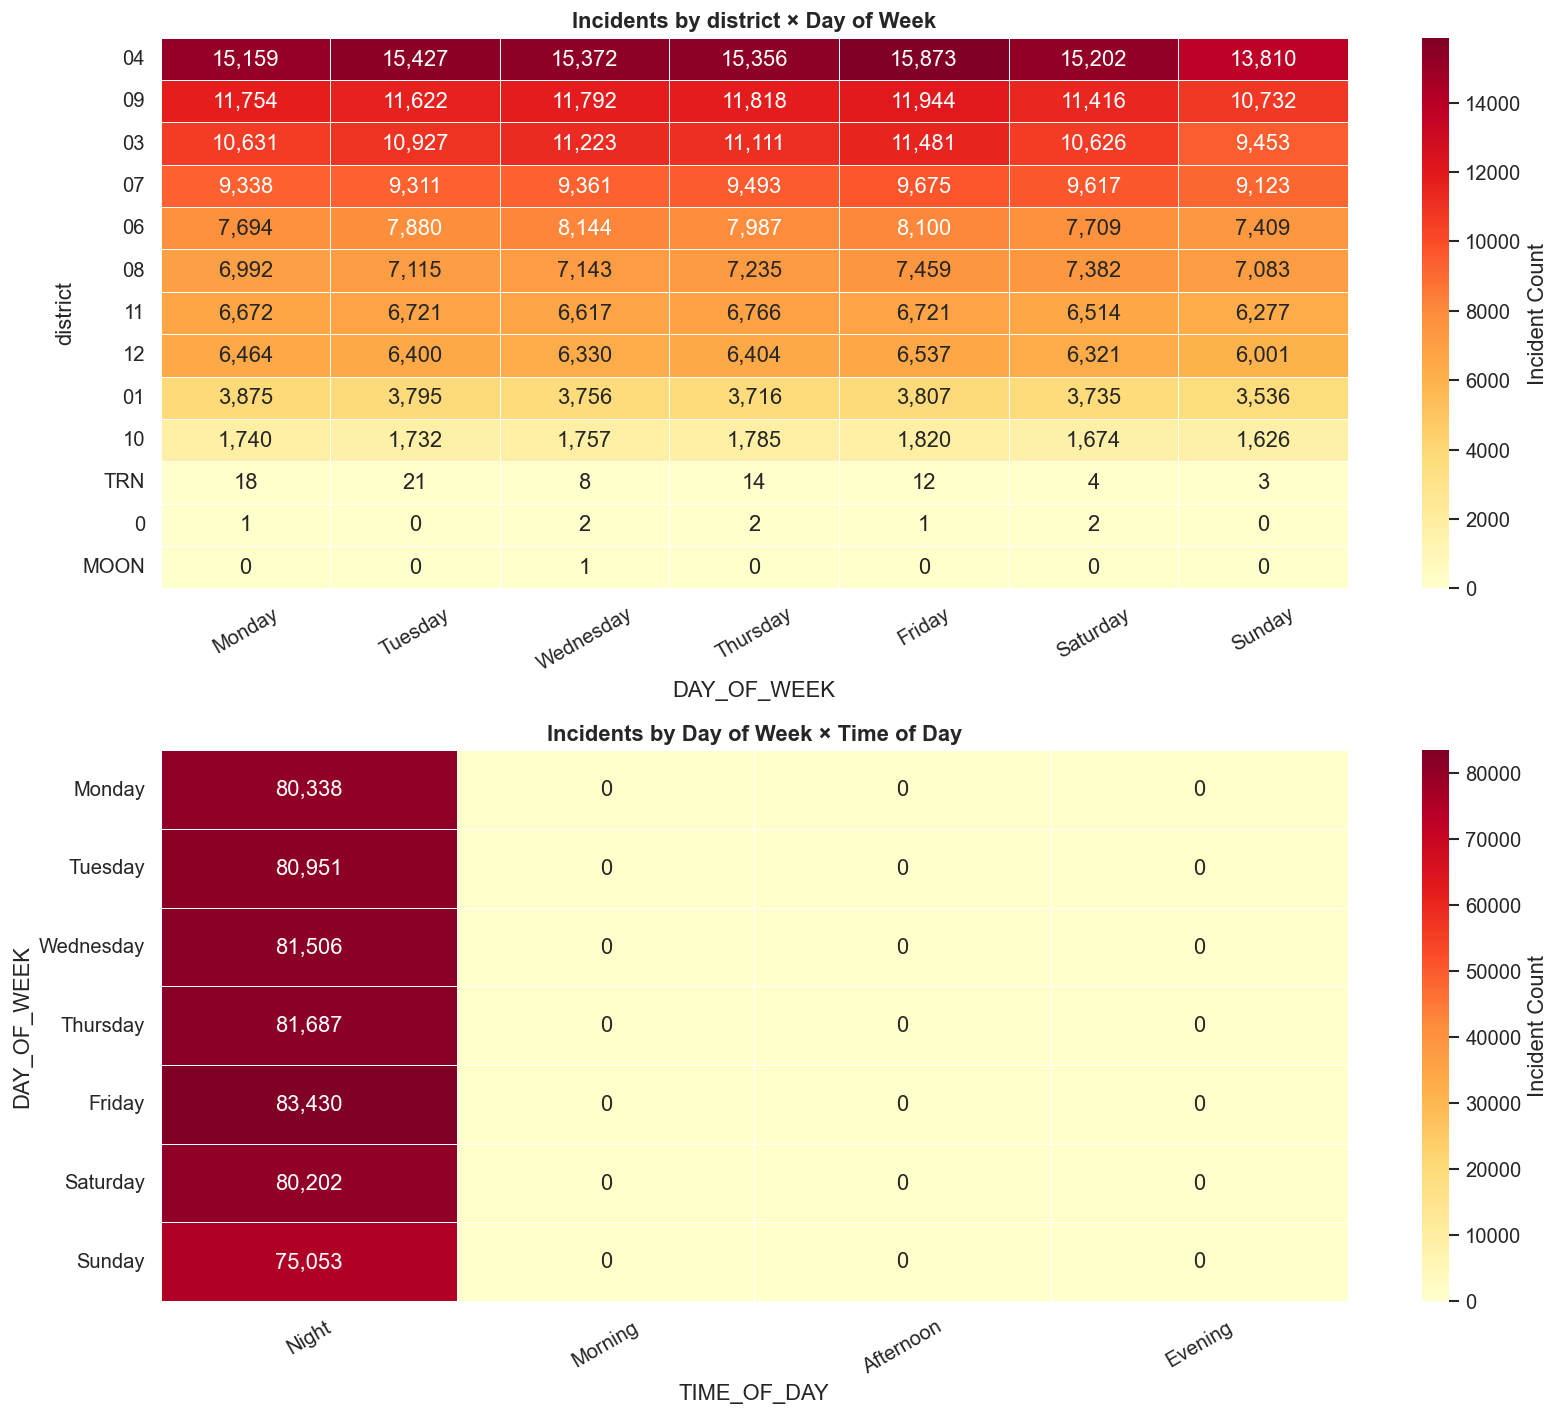

In [9]:
# ── Heatmaps ─────────────────────────────────────────────────────────────────
plot_pairs = []
if district_col and "DAY_OF_WEEK" in df.columns:
    plot_pairs.append((district_col, "DAY_OF_WEEK",
                       f"Incidents by {district_col} × Day of Week"))
if "DAY_OF_WEEK" in df.columns and "TIME_OF_DAY" in df.columns:
    plot_pairs.append(("DAY_OF_WEEK", "TIME_OF_DAY",
                       "Incidents by Day of Week × Time of Day"))

fig, axes = plt.subplots(len(plot_pairs), 1,
                          figsize=(14, 6 * max(len(plot_pairs), 1)))
if len(plot_pairs) == 1:
    axes = [axes]

for ax, (row_col, col_col, title) in zip(axes, plot_pairs):
    pivot = (
        df.groupby([row_col, col_col]).size()
          .unstack(fill_value=0)
    )
    if col_col == "DAY_OF_WEEK":
        pivot = pivot.reindex(columns=day_order, fill_value=0)
        pivot = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).index]
    elif col_col == "TIME_OF_DAY":
        pivot = pivot.reindex(index=day_order, columns=time_order, fill_value=0)

    sns.heatmap(pivot, ax=ax, cmap="YlOrRd", fmt=",d", annot=True,
                linewidths=0.5, cbar_kws={"label": "Incident Count"})
    ax.set_title(title, fontweight="bold")
    ax.tick_params(axis="x", rotation=30)
    ax.tick_params(axis="y", rotation=0)

plt.tight_layout()
plt.show()

#### Top Incident Types

The most frequent incident categories dominate the dataset. If a small number of incident types (e.g., EMS calls, false alarms) overwhelmingly drive the record count, predictive models may become biased toward common, low-severity events.

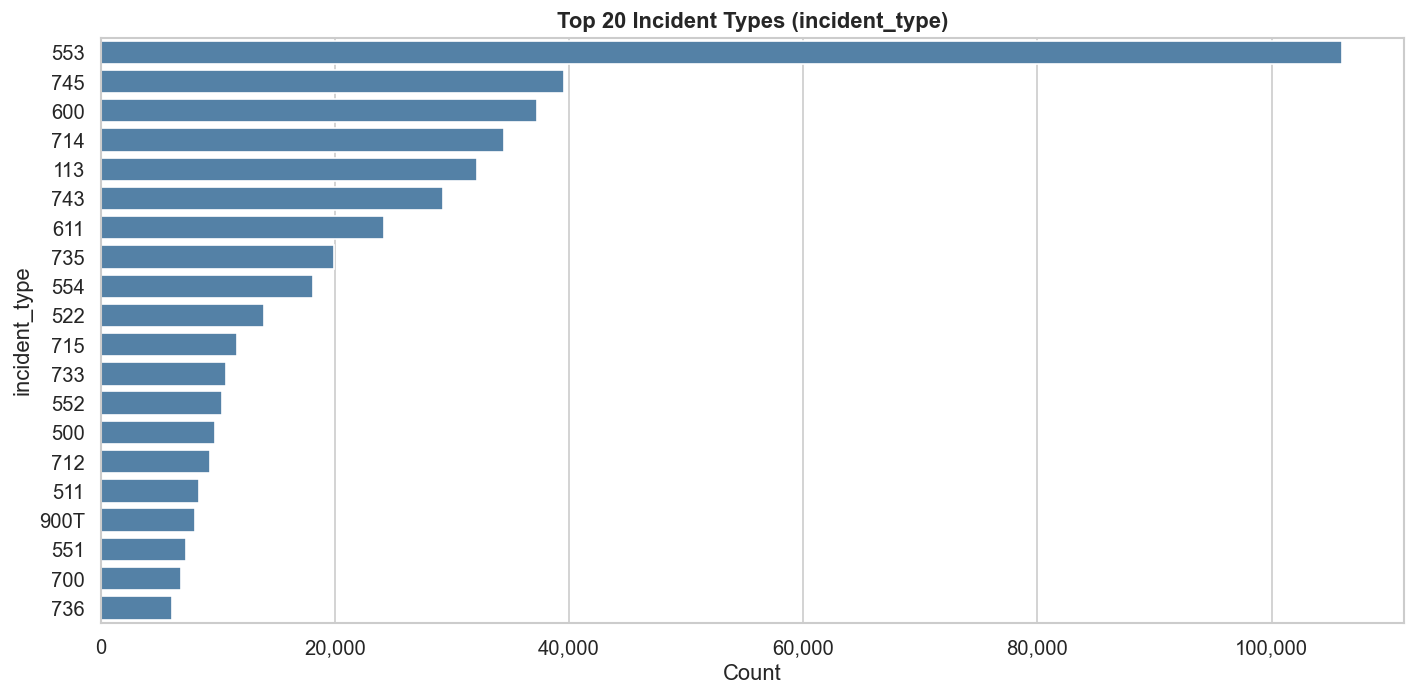

In [10]:
# ── Top incident types bar chart ──────────────────────────────────────────────
if type_col:
    fig, ax = plt.subplots(figsize=(12, 6))
    vc = df[type_col].value_counts().head(20)
    sns.barplot(x=vc.values, y=vc.index.astype(str), ax=ax,
                orient="h", color="steelblue")
    ax.set_title(f"Top 20 Incident Types ({type_col})", fontweight="bold")
    ax.set_xlabel("Count")
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))
    plt.tight_layout()
    plt.show()

### 2.3 Temporal Trends

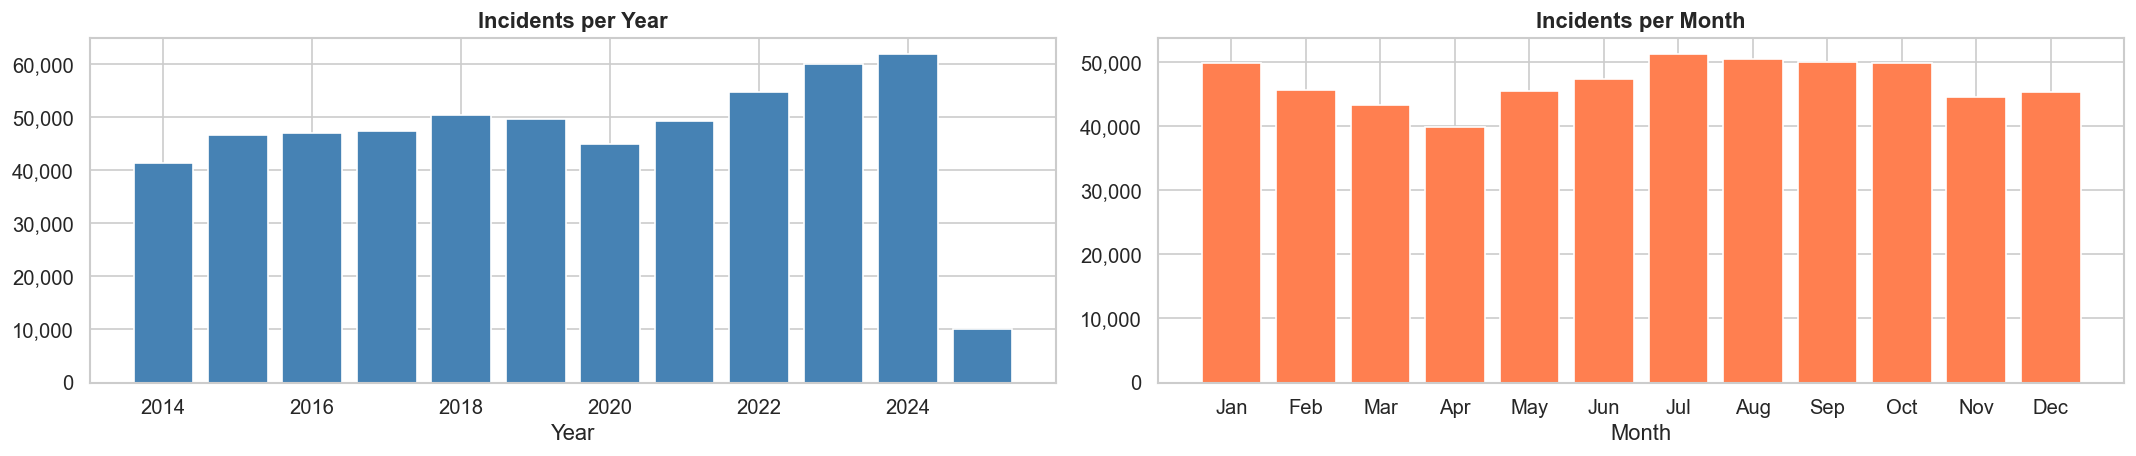

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(18, 4))

if "YEAR" in df.columns:
    yr = df["YEAR"].value_counts().sort_index()
    axes[0].bar(yr.index.astype(int), yr.values, color="steelblue", edgecolor="white")
    axes[0].set_title("Incidents per Year", fontweight="bold")
    axes[0].set_xlabel("Year")
    axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

if "MONTH" in df.columns:
    mo = df["MONTH"].value_counts().sort_index()
    month_labels = ["Jan","Feb","Mar","Apr","May","Jun",
                    "Jul","Aug","Sep","Oct","Nov","Dec"]
    axes[1].bar([month_labels[int(m)-1] for m in mo.index],
                mo.values, color="coral", edgecolor="white")
    axes[1].set_title("Incidents per Month", fontweight="bold")
    axes[1].set_xlabel("Month")
    axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

plt.tight_layout()
plt.show()

### 2.4 Financial Loss Distribution

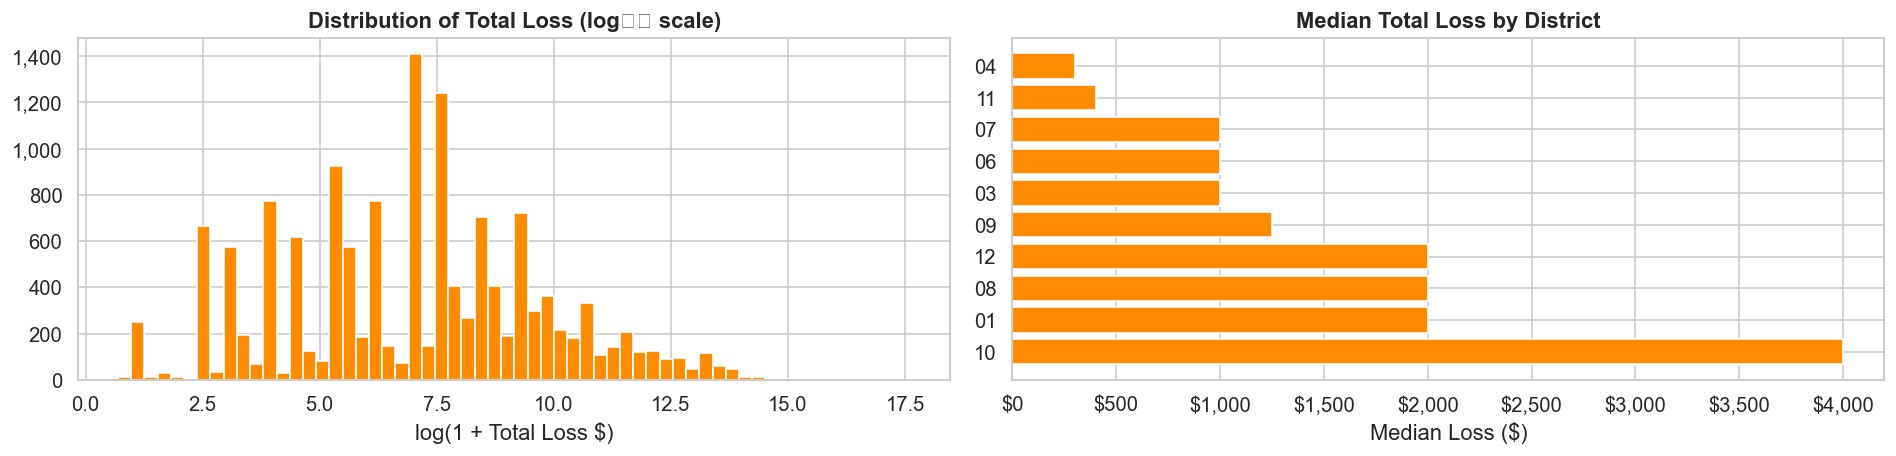


Total Loss Summary ($):


,total_loss
count,"$14,272.00"
mean,"$36,730.49"
std,"$441,383.99"
min,$1.00
25%,$200.00
50%,"$1,000.00"
75%,"$7,000.00"
max,"$45,000,000.00"


In [13]:
df["total_loss"] = (
    df["estimated_property_loss"].fillna(0) +
    df["estimated_content_loss"].fillna(0)
)
df.loc[df["total_loss"] == 0, "total_loss"] = np.nan
loss_data = df["total_loss"].dropna()

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Log-scale histogram (loss spans many orders of magnitude)
axes[0].hist(np.log1p(loss_data), bins=60, color="darkorange", edgecolor="white")
axes[0].set_title("Distribution of Total Loss (log₁₊ scale)", fontweight="bold")
axes[0].set_xlabel("log(1 + Total Loss $)")
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

# Median loss by district
med_loss = (
    df.groupby("district")["total_loss"].median()
      .sort_values(ascending=False)
)
axes[1].barh(med_loss.index.astype(str), med_loss.values, color="darkorange")
axes[1].set_title("Median Total Loss by District", fontweight="bold")
axes[1].set_xlabel("Median Loss ($)")
axes[1].xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x:,.0f}"))

plt.tight_layout()
plt.show()

print("\nTotal Loss Summary ($):")
display(loss_data.describe().rename("total_loss").to_frame().applymap(lambda x: f"${x:,.2f}"))

---
## 3 · Data Slicing for Bias Detection

Fire incident data lacks individual demographic attributes. We use **structural proxies** as slicing dimensions:

| Dimension | Column | Rationale |
|---|---|---|
| Geographic | `district` | Uneven resource allocation / patrol coverage |
| Neighborhood | `neighborhood` | Socioeconomic proxy for reporting equity |
| Incident severity | `incident_type` | Over/under-reporting by category |
| Property type | `property_use` | Residential vs commercial bias |
| Time of day | `TIME_OF_DAY` | Shift-level reporting or coverage gaps |
| Financial impact | `total_loss` | Equity in loss concentration by area |

Representational bias appears as certain districts or time windows having disproportionately many/few records, or systematically higher losses, indicating selective reporting, uneven patrol coverage, or data gaps.

### 3.1 Slice-level Record Counts & Share

In [14]:
def slice_summary(df: pd.DataFrame, col: str, top_n: int = 20) -> pd.DataFrame:
    """Return count, share %, and average missing-value rate per slice."""
    vc  = df[col].value_counts(dropna=False).head(top_n).rename("count")
    pct = (vc / len(df) * 100).rename("share_%").round(2)

    tmp = "__slice__"
    df[tmp] = df[col].astype(str).fillna("NaN")
    miss = (
        df.groupby(tmp)
          .apply(lambda g: g.drop(columns=tmp).isnull().mean().mean() * 100)
          .rename("avg_missing_%")
          .round(2)
    )
    df.drop(columns=tmp, inplace=True)

    vc.index  = vc.index.astype(str).fillna("NaN")
    pct.index = pct.index.astype(str).fillna("NaN")
    return pd.concat([vc, pct, miss], axis=1).reindex(vc.index)


for dim in ["district", "incident_type", "TIME_OF_DAY", "property_use"]:
    print(f"\n── Slice: {dim} ─────────────────────────")
    display(slice_summary(df, dim))


── Slice: district ─────────────────────────


,count,share_%,avg_missing_%
district,,,
04,106199,18.86,4.84
09,81078,14.40,4.71
03,75452,13.40,5.22
07,65918,11.70,4.96
06,54923,9.75,5.04
08,50409,8.95,4.72
11,46288,8.22,4.60
12,44457,7.89,4.74
01,26220,4.66,4.78



── Slice: incident_type ─────────────────────────


,count,share_%,avg_missing_%
incident_type,,,
553,106036.0,18.83,4.93
745,39563.0,7.03,4.12
600,37281.0,6.62,5.17
714,34403.0,6.11,4.16
113,32102.0,5.70,3.56
743,29247.0,5.19,4.16
611,24192.0,4.30,11.83
735,19911.0,3.54,4.16
554,18113.0,3.22,4.15



── Slice: TIME_OF_DAY ─────────────────────────


,count,share_%,avg_missing_%
TIME_OF_DAY,,,
Night,563167,100.0,4.86
Morning,0,0.0,NaN
Afternoon,0,0.0,NaN
Evening,0,0.0,NaN



── Slice: property_use ─────────────────────────


,count,share_%,avg_missing_%
property_use,,,
429,148173.0,26.31,4.03
400,61581.0,10.93,4.05
900,54299.0,9.64,5.38
419,44354.0,7.88,4.03
960,29364.0,5.21,5.79
None,23475.0,4.17,12.71
962,22246.0,3.95,5.44
963,19267.0,3.42,5.93
500,18541.0,3.29,4.18


### 3.2 Visualising Slice Imbalance

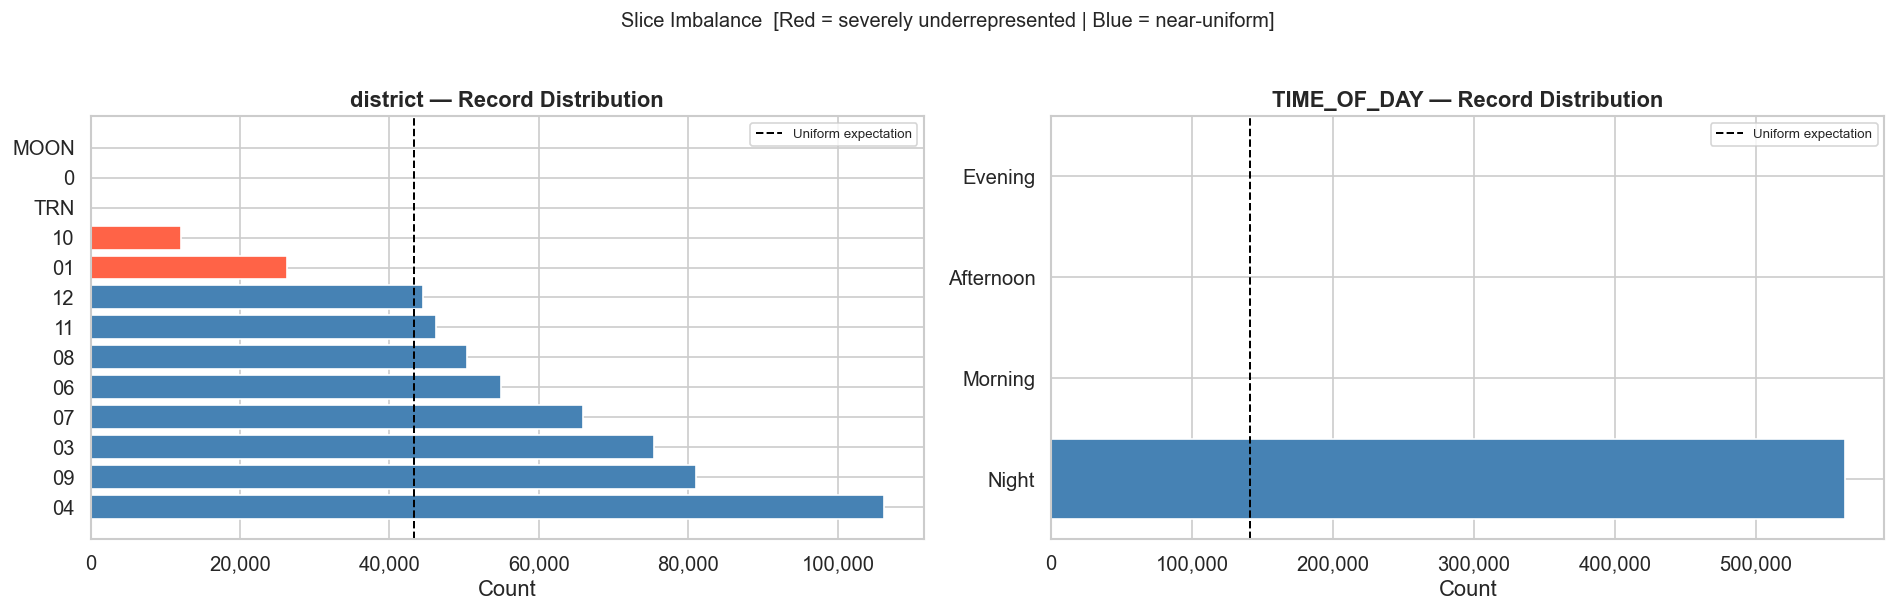

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for ax, dim in zip(axes, ["district", "TIME_OF_DAY"]):
    vc       = df[dim].value_counts(dropna=False)
    expected = len(df) / len(vc)
    colors   = ["tomato" if v < expected * 0.7 else
                "gold"   if v < expected * 0.9 else
                "steelblue" for v in vc.values]
    ax.barh(vc.index.astype(str), vc.values, color=colors)
    ax.axvline(expected, color="black", linestyle="--", linewidth=1.2,
               label="Uniform expectation")
    ax.set_title(f"{dim} — Record Distribution", fontweight="bold")
    ax.set_xlabel("Count")
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))
    ax.legend(fontsize=8)

plt.suptitle("Slice Imbalance  [Red = severely underrepresented | Blue = near-uniform]",
             y=1.02, fontsize=12)
plt.tight_layout()
plt.show()

### 3.3 Slice-level Missing-Value Rate (Reporting Bias Proxy)

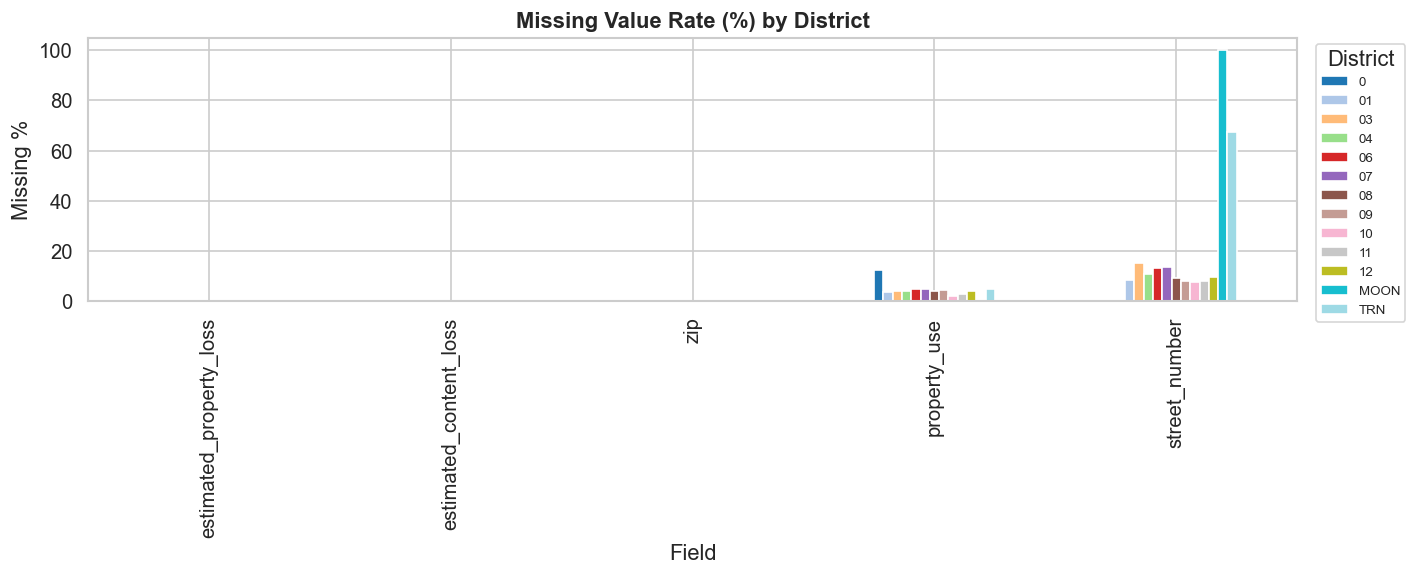

,estimated_property_loss,estimated_content_loss,zip,property_use,street_number
district,,,,,
0,0.0,0.0,0.0,12.50,0.00
01,0.0,0.0,0.0,3.72,8.47
03,0.0,0.0,0.0,4.27,15.34
04,0.0,0.0,0.0,4.02,10.67
06,0.0,0.0,0.0,4.88,13.35
07,0.0,0.0,0.0,5.06,13.71
08,0.0,0.0,0.0,4.07,9.38
09,0.0,0.0,0.0,4.44,7.90
10,0.0,0.0,0.0,2.23,7.75


In [16]:
# xstreet_* and street_prefix/suffix already dropped — only track actionable fields
key_cols = ["estimated_property_loss", "estimated_content_loss",
            "zip", "property_use", "street_number"]
miss_by_district = (
    df.groupby("district", dropna=False)[key_cols]
      .apply(lambda g: g.isnull().mean() * 100)
      .round(2)
)

fig, ax = plt.subplots(figsize=(12, 5))
miss_by_district.T.plot(kind="bar", ax=ax, colormap="tab20", edgecolor="white")
ax.set_title("Missing Value Rate (%) by District", fontweight="bold")
ax.set_ylabel("Missing %")
ax.set_xlabel("Field")
ax.legend(title="District", bbox_to_anchor=(1.01, 1), fontsize=8)
plt.tight_layout()
plt.show()
display(miss_by_district)

### 3.4 Neighborhood Missingness as a Bias Indicator

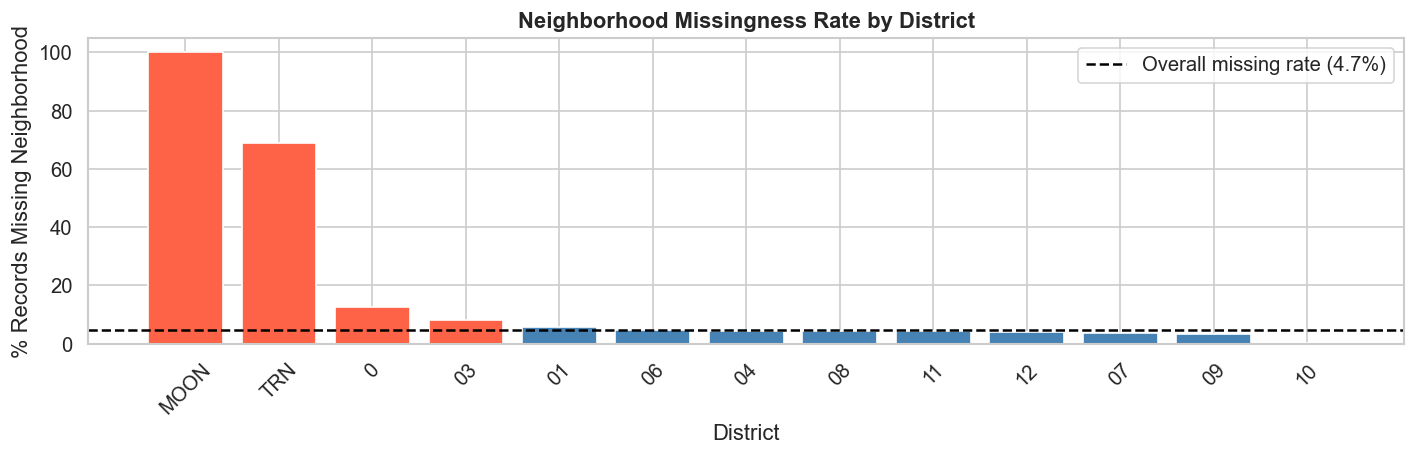

,neighborhood_missing_%
district,
MOON,100.00
TRN,68.75
0,12.50
03,8.09
01,5.66
06,4.71
04,4.44
08,4.39
11,4.35


In [17]:
# Uneven neighborhood missingness across districts suggests some areas are
# systematically under-described — a form of reporting/documentation bias.

nbhd_miss_by_dist = (
    df.groupby("district")["neighborhood_missing"]
      .mean()
      .mul(100)
      .round(2)
      .sort_values(ascending=False)
      .rename("neighborhood_missing_%")
)
overall_miss_rate = df["neighborhood_missing"].mean() * 100

fig, ax = plt.subplots(figsize=(12, 4))
colors = ["tomato" if v > overall_miss_rate * 1.5 else "steelblue"
          for v in nbhd_miss_by_dist.values]
ax.bar(nbhd_miss_by_dist.index.astype(str), nbhd_miss_by_dist.values,
       color=colors, edgecolor="white")
ax.axhline(overall_miss_rate, color="black", linestyle="--",
           label=f"Overall missing rate ({overall_miss_rate:.1f}%)")
ax.set_title("Neighborhood Missingness Rate by District", fontweight="bold")
ax.set_ylabel("% Records Missing Neighborhood")
ax.set_xlabel("District")
ax.tick_params(axis="x", rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

display(nbhd_miss_by_dist.to_frame())

### 3.5 Financial Loss Equity by District & Neighborhood


Loss statistics by district:


,median,mean,count,total
district,,,,
10,4000.0,39840.39,211,8406322.0
01,2000.0,94126.32,567,53369625.0
08,2000.0,56470.31,2043,115368850.0
12,2000.0,40052.48,1341,53710375.0
09,1250.0,22718.26,1958,44482353.0
03,1000.0,43428.37,1061,46077497.0
06,1000.0,35545.22,1072,38104473.0
07,1000.0,36504.87,2376,86735561.0
11,400.0,27205.37,1285,34958900.0


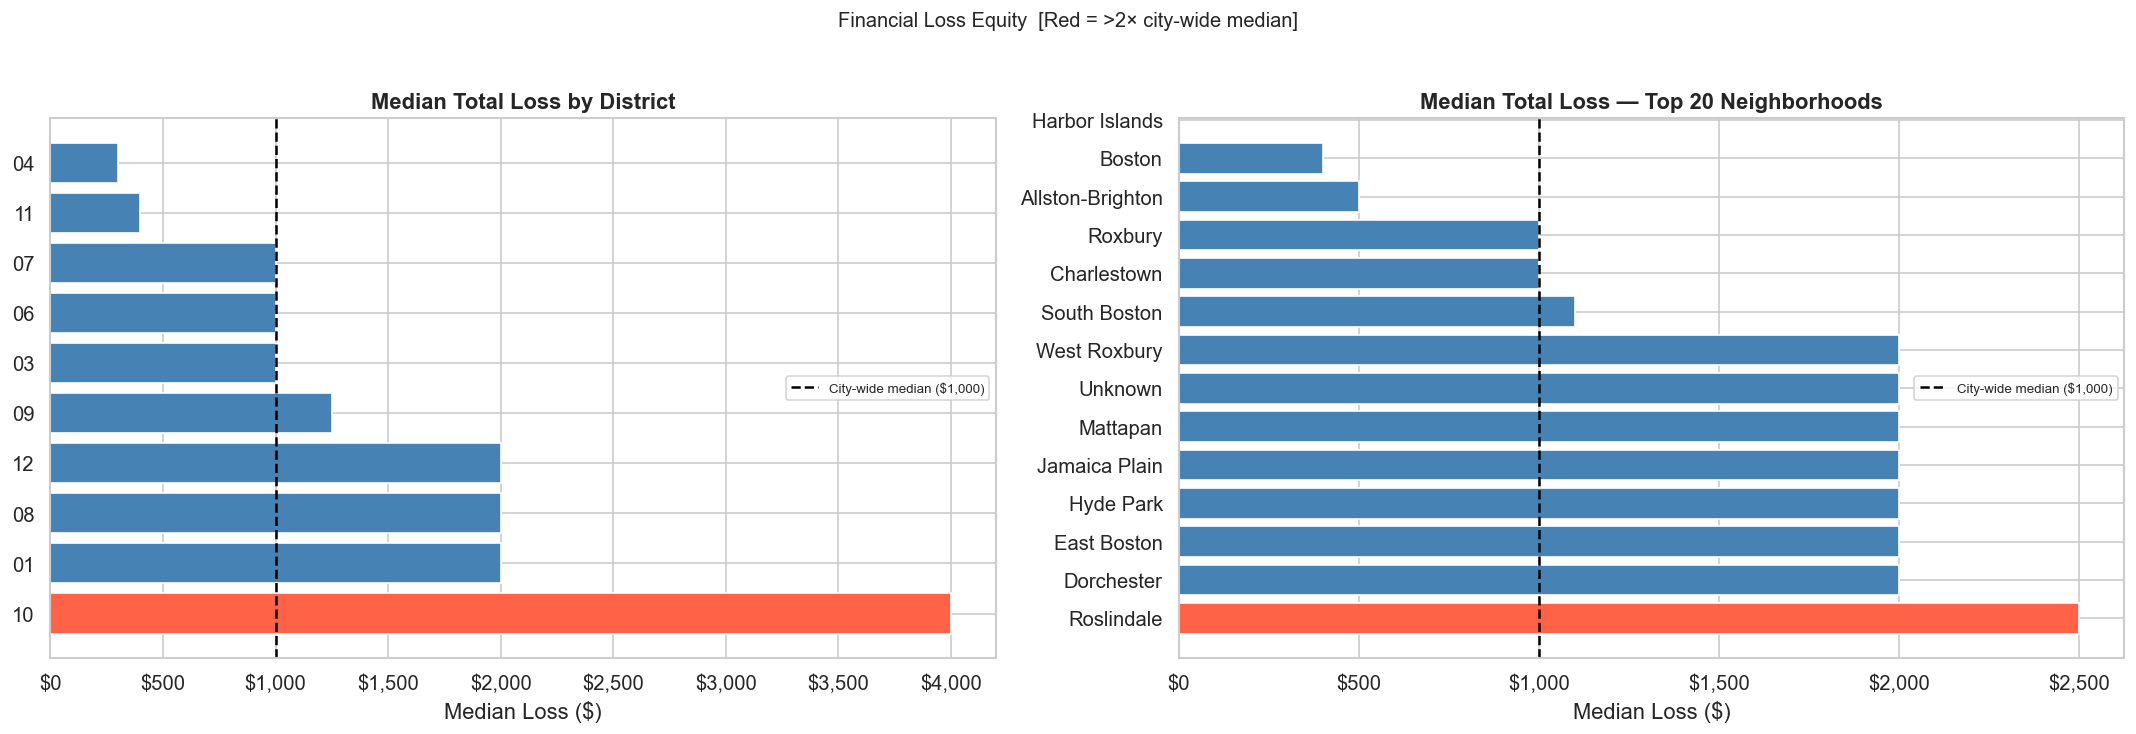

In [18]:
loss_by_district = (
    df.groupby("district")["total_loss"]
      .agg(median="median", mean="mean", count="count", total="sum")
      .sort_values("median", ascending=False)
      .round(2)
)
print("\nLoss statistics by district:")
display(loss_by_district)

loss_by_nbhd = (
    df.groupby("neighborhood")["total_loss"]
      .agg(median="median", count="count")
      .sort_values("median", ascending=False)
      .head(20)
      .round(2)
)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
for ax, data, col, title in [
    (axes[0], loss_by_district, "median", "Median Total Loss by District"),
    (axes[1], loss_by_nbhd,    "median", "Median Total Loss — Top 20 Neighborhoods"),
]:
    overall = df["total_loss"].median()
    colors  = ["tomato" if v > overall * 2 else "steelblue" for v in data[col].values]
    ax.barh(data.index.astype(str), data[col].values, color=colors)
    ax.axvline(overall, color="black", linestyle="--",
               label=f"City-wide median (${overall:,.0f})")
    ax.set_title(title, fontweight="bold")
    ax.set_xlabel("Median Loss ($)")
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x:,.0f}"))
    ax.legend(fontsize=8)

plt.suptitle("Financial Loss Equity  [Red = >2× city-wide median]",
             y=1.02, fontsize=12)
plt.tight_layout()
plt.show()

---
## 4 · Bias Mitigation

After detecting imbalances we apply **two complementary strategies**:

| Strategy | Technique | Applied to |
|---|---|---|
| **Re-sampling** | Oversample underrepresented districts to the median count | `district` |
| **Threshold Flagging** | Flag districts with median financial loss ≥ 2× city-wide median | `total_loss` by `district` |

### 4.1 Oversampling Underrepresented Districts

Target (median) count per district: 46,288
Resampled dataset shape: (601744, 25)


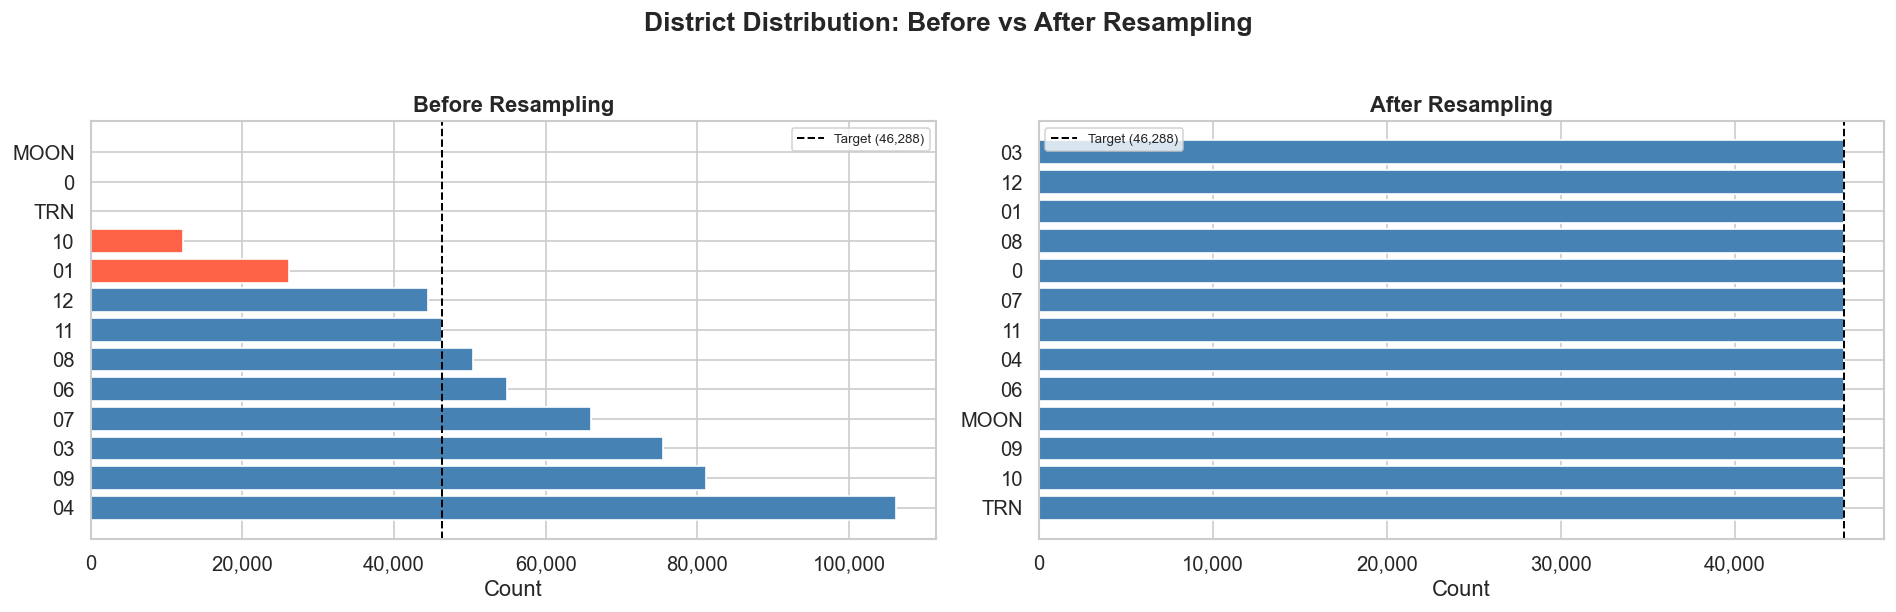

In [19]:
district_counts = df["district"].value_counts(dropna=True)
target = int(district_counts.median())
print(f"Target (median) count per district: {target:,}")

resampled_parts = []
for district, grp in df.groupby("district", dropna=True):
    n = len(grp)
    if n < target:
        extra = grp.sample(target - n, replace=True, random_state=42)
        resampled_parts.append(pd.concat([grp, extra], ignore_index=True))
    else:
        resampled_parts.append(grp.sample(target, replace=False, random_state=42))

df_resampled = pd.concat(resampled_parts, ignore_index=True).sample(frac=1, random_state=42)
print(f"Resampled dataset shape: {df_resampled.shape}")

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
for ax, data, title in [
    (axes[0], df,           "Before Resampling"),
    (axes[1], df_resampled, "After Resampling"),
]:
    vc = data["district"].value_counts()
    ax.barh(
        vc.index.astype(str), vc.values,
        color=["tomato" if v < target * 0.8 else "steelblue" for v in vc.values]
    )
    ax.axvline(target, color="black", linestyle="--", linewidth=1.2,
               label=f"Target ({target:,})")
    ax.set_title(title, fontweight="bold")
    ax.set_xlabel("Count")
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))
    ax.legend(fontsize=8)

plt.suptitle("District Distribution: Before vs After Resampling",
             fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()


### 4.2 Threshold Flagging — High Financial-Loss Districts

City-wide median loss  : $1,000.00
Flagging threshold     : $2,000.00  (2× city-wide)

Flagged districts (4):


,median_total_loss
district,
10,"$4,000.00"
01,"$2,000.00"
08,"$2,000.00"
12,"$2,000.00"


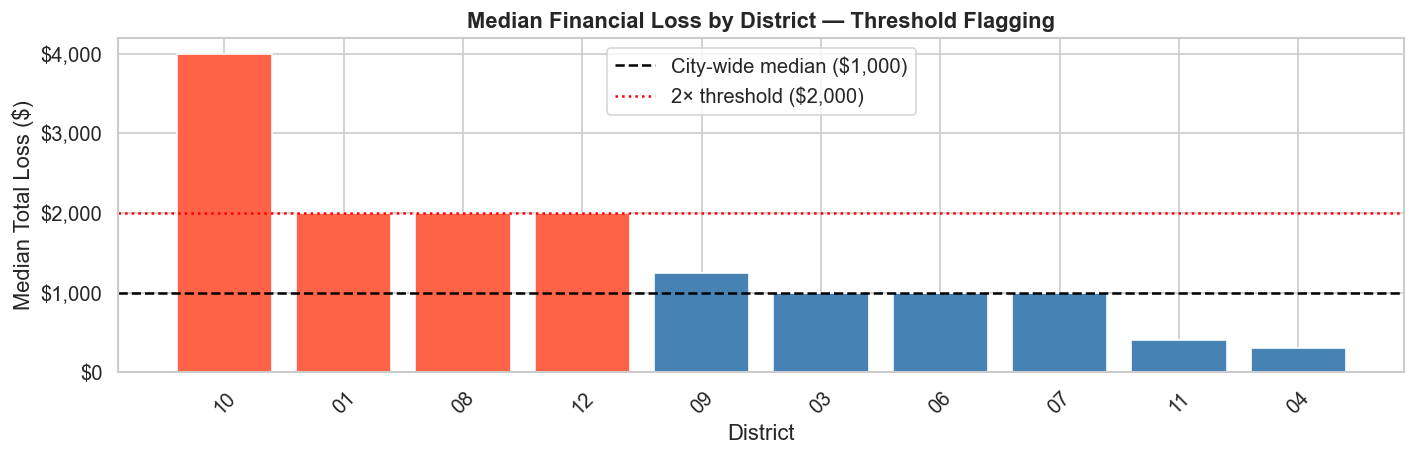

In [20]:
loss_medians   = df.groupby("district")["total_loss"].median().sort_values(ascending=False)
overall_median = df["total_loss"].median()
flag_threshold = 2.0 * overall_median

flagged = loss_medians[loss_medians >= flag_threshold]
print(f"City-wide median loss  : ${overall_median:,.2f}")
print(f"Flagging threshold     : ${flag_threshold:,.2f}  (2× city-wide)")
print(f"\nFlagged districts ({len(flagged)}):")
display(flagged.rename("median_total_loss").to_frame()
               .applymap(lambda x: f"${x:,.2f}"))

fig, ax = plt.subplots(figsize=(12, 4))
colors = ["tomato" if v >= flag_threshold else "steelblue"
          for v in loss_medians.values]
ax.bar(loss_medians.index.astype(str), loss_medians.values,
       color=colors, edgecolor="white")
ax.axhline(overall_median, color="black", linestyle="--",
           label=f"City-wide median (${overall_median:,.0f})")
ax.axhline(flag_threshold, color="red",   linestyle=":",
           label=f"2× threshold (${flag_threshold:,.0f})")
ax.set_title("Median Financial Loss by District — Threshold Flagging",
             fontweight="bold")
ax.set_ylabel("Median Total Loss ($)")
ax.set_xlabel("District")
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x:,.0f}"))
ax.tick_params(axis="x", rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

---
## 5 · Bias Detection & Mitigation — Summary

### Types of Bias Identified

| Bias Type | Description | Detected In |
|---|---|---|
| **Representational Bias** | Certain districts have far more/fewer records, indicating uneven fire-resource deployment or differential reporting rates. | District slice imbalance chart |
| **Reporting / Missingness Bias** | Missing rates for financial loss, zip, neighborhood differ by district. Incidents in some areas carry systematically less detail. | Missing-value-by-district heatmap |
| **Temporal Bias** | Incident counts peak at specific hours/months, possibly reflecting staffing or reporting patterns rather than true fire risk. | Hour / Month bar charts |
| **Neighborhood Missingness Bias** | ~4.7% of records lack a neighborhood label, and the missing rate varies significantly by district — areas with higher missingness are structurally under-described. | Neighborhood missingness-by-district bar |
| **Severity / Category Imbalance** | Certain incident types (e.g., EMS calls) overwhelmingly dominate, which can skew predictive models toward common, low-severity events. | incident_type / description charts |

### Mitigation Steps Taken

1. **Re-sampling (District)** — Underrepresented districts oversampled (with replacement) and dominant districts downsampled to the median district count, ensuring equal geographic representation for downstream modelling.
2. **Threshold Flagging (Financial Loss)** — Districts with median total loss ≥ 2× city-wide median are flagged for priority review, guiding resource allocation decisions and stricter model output audits.

### Trade-offs

| Trade-off | Description |
|---|---|
| **Accuracy ↔ Fairness** | Oversampling small districts introduces synthetic records, slightly reducing the model's ability to reflect true city-wide incident rates. |
| **Recall ↔ Precision** | Lower loss thresholds flag more districts (higher recall) but risk over-intervention in areas with naturally larger commercial properties. |
| **Data size** | Resampling changes the total dataset size; experiments should note whether `df` or `df_resampled` was used for training. |

**Next steps:** Apply `df_resampled` when training predictive models. Re-evaluate metrics using Fairlearn's `MetricFrame` on a held-out test set stratified by `district` and `property_use` to confirm bias has been adequately reduced.